In [1]:
import numpy as np
import matplotlib.pyplot as plt
from layers import *
from gradientCheck import *
from relativeError import *
from fcnet import *
from Trainer import *
%reload_ext autoreload
%autoreload 2


## 看affine_forward是否实现正确

In [2]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ',relative_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984772881e-10


## 梯度检查： 看affine_backward是否实现正确

In [3]:
np.random.seed(231)

X = np.random.rand(60).reshape(3, 4, 5)

W = np.random.randn(20, 5)

b = np.random.rand(5)

out, cache = affine_forward(X, W, b)

dout = 10 * np.random.randn(*out.shape)

f_X = lambda x: affine_forward(x, W, b)[0]

f_W = lambda w: affine_forward(X, w, b)[0]

f_b = lambda b: affine_forward(X, W, b)[0]

dX_num = numerical_gradient(f_X, X, dout)

dW_num = numerical_gradient(f_W, W, dout)

db_num = numerical_gradient(f_b, b, dout)
print(np.sum(dX_num))

dX, dW, db = affine_backward(dout, cache)

print(np.sum(dX))


print('dX relative error: ',relative_error(dX, dX_num))

print('dW relative error: ',relative_error(dW, dW_num))

print('db relative error: ',relative_error(db, db_num))

162.720377666
162.720377669
dX relative error:  4.49923355477e-10
dW relative error:  1.38140535474e-09
db relative error:  2.72717852923e-11


## 梯度检查： 看relu_backward是否实现正确

In [4]:
X = np.random.randn(3, 4)

print(X)

out, cache = relu_forward(X)

dout = np.random.randn(*out.shape)

dX = relu_backward(dout, cache)


f = lambda x: relu_forward(x)[0]

dX_num = numerical_gradient(f, X, dout)

print('dX relative error: ',relative_error(dX, dX_num))

[[ 0.08706084 -0.39078755 -0.53630667 -0.0694466 ]
 [ 1.19596293 -1.23569345 -0.53806511 -0.6078434 ]
 [ 0.92544992  0.28567297 -0.5000103  -0.88501449]]
dX relative error:  3.27560929819e-12


## 梯度检查： 看affine_relu_backward是否实现正确

In [5]:
np.random.seed(231)

X = np.random.rand(60).reshape(3, 4, 5)

W = np.random.randn(20, 5)

b = np.random.rand(5)

out, cache = affine_relu_forward(X, W, b)

dout = 10 * np.random.randn(*out.shape)

f_X = lambda x: affine_relu_forward(x, W, b)[0]

f_W = lambda w: affine_relu_forward(X, w, b)[0]

f_b = lambda b: affine_relu_forward(X, W, b)[0]

dX_num = numerical_gradient(f_X, X, dout)

dW_num = numerical_gradient(f_W, W, dout)

db_num = numerical_gradient(f_b, b, dout)
print(np.sum(dX_num))

dX, dW, db = affine_relu_backward(dout, cache)

print(np.sum(dX))


print('dX relative error: ',(relative_error(dX, dX_num)))

print('dW relative error: ',(relative_error(dW, dW_num)))

print('db relative error: ',(relative_error(db, db_num)))

-1.77546717238
-1.77546717233
dX relative error:  8.22096101856e-11
dW relative error:  2.02296859154e-10
db relative error:  5.00054605599e-13


In [6]:
scores = np.random.randn(50, 6)

y = np.random.randint(6, size=(50, ))

loss, dscores = softmax_loss(scores, y)

loss_true, dscores_true = softmax_loss_true(scores, y)

dout = 1

f_sc = lambda scores: softmax_loss_true(scores, y)[0]

dscores_num = numerical_gradient(f_sc, scores, dout)

dscores_num2 = eval_numerical_gradient(f_sc, scores, verbose=False)

print('dscores relative error: ',(relative_error(dscores_true, dscores)))


dscores relative error:  3.56982465388e-16


## 需要实现一个任意层神经网络模型类

In [7]:
np.random.seed(666)
X = np.random.randn(50, 3, 4)
N = X.shape[0]
input_dim = X.reshape(N, -1).shape[1]
y = np.random.randint(6, size=(N, ))
fcnet = FullyConnectNet(layers=[10, 10, 6], input_dim=input_dim, reg=0.3)

In [8]:
loss, grads = fcnet.loss(X, y)

In [9]:
print(loss)
for key, val in grads.items():
    print(key, val.shape)

68.0233988609
W3 (10, 6)
b3 (6,)
W2 (10, 10)
b2 (10,)
W1 (12, 10)
b1 (10,)


## 下面梯度检查，看grads是否正确

## 接下来实现公用的训练器Trainer

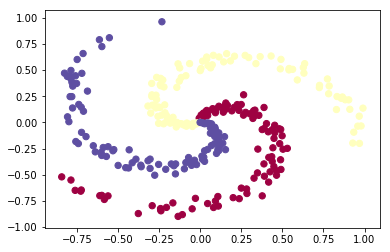

In [27]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

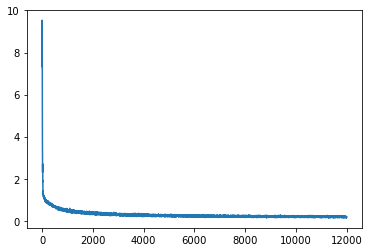

0.203788662257
0.976666666667


In [74]:
data = {
    'X_train': X,
    'y_train': y,
    'X_val': None,
    'y_val': None
}

test_net = FullyConnectNet(layers=[10, 10, K], input_dim=D, reg=1e-3)
trainer = Trainer(test_net, data, batch_size=150, epoch_nums=6000, learning_rate=1e-2)

loss_cache = trainer.train()

plt.plot(np.arange(len(loss_cache)), loss_cache)

plt.show()

print(loss_cache[-1])

print(trainer.check_train_accuracy())

## 画出决策边界

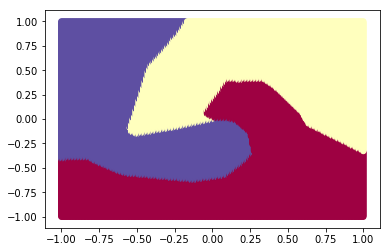

In [122]:
spaced = 200

test_X = np.zeros((spaced ** 2, 2))

x_nums = np.linspace(-1, 1, spaced)

for i in range(spaced):
    
    test_X[i*spaced: i*spaced + spaced][:, 0] = np.ones(spaced) * x_nums[i]
    
    test_X[i*spaced: i*spaced + spaced][:, 1] = np.linspace(-1, 1, spaced)
    
labels = test_net.predict(test_X)
plt.scatter(test_X[:, 0], test_X[:, 1], c=labels, s=30, cmap=plt.cm.Spectral)
plt.show()